In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mne
# import pyedflib
import os
import glob
# import tensorflow as tf
from tqdm import tqdm
from lxml import etree

In [2]:
BASE_DB_PATH = '/mnt/dat/databases/shhs/polysomnography'
TO_PATH = '/mnt/dat/prepped/apnea_sp02_pr'

SAMPLING_RATE = 1.0 

SEGMENT_LENGTH = 150 # input to model
SINGLE_ANNOT = 30 # annotate for every 30s

# consider only below channels
SELECTED_CHANNELS = ['SaO2', 'H.R.', 'PR', 'OX stat', 'OX STAT']

In [3]:
shhs1_edfs = glob.glob(os.path.join(BASE_DB_PATH, 'edfs/shhs1/*.edf'))
shhs2_edfs = glob.glob(os.path.join(BASE_DB_PATH, 'edfs/shhs2/*.edf'))
shhs1_edfs = sorted(shhs1_edfs)[:10] # only get samples
shhs2_edfs = sorted(shhs2_edfs)[:10]

len(shhs1_edfs), len(shhs2_edfs)

(10, 10)

In [4]:
shhs1_xmls = glob.glob(os.path.join(BASE_DB_PATH, 'annotations-events-nsrr/shhs1/*.xml'))
shhs2_xmls = glob.glob(os.path.join(BASE_DB_PATH, 'annotations-events-nsrr/shhs2/*.xml'))
shhs1_xmls = sorted(shhs1_xmls)[:10]
shhs2_xmls = sorted(shhs2_xmls)[:10]

len(shhs1_xmls), len(shhs2_xmls)

(10, 10)

# Examine a sample record

In [5]:
def get_edf(path, channels):
    return mne.io.read_raw_edf(path, include=channels, 
                               verbose=False, preload=False)

In [6]:
edf = get_edf(shhs1_edfs[0], SELECTED_CHANNELS)
edf

<RawEDF | shhs1-200001.edf, 3 x 32520 (32519.0 s), ~9 kB, data not loaded>

32520


<Axes: >

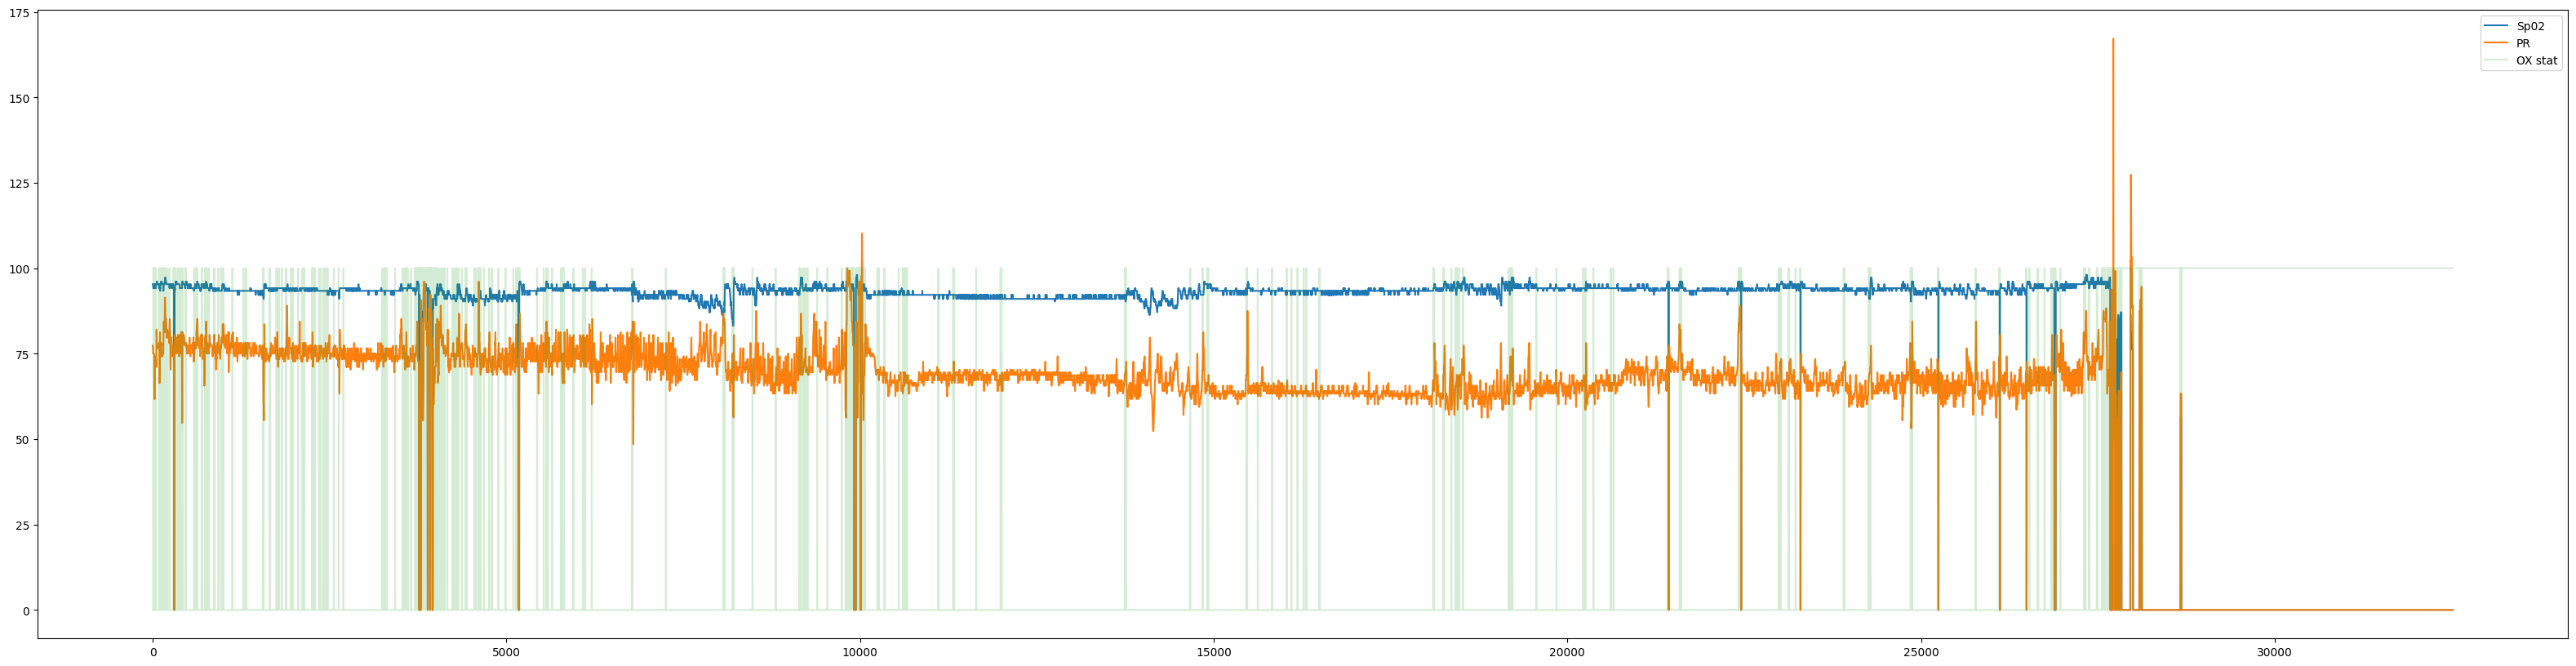

In [7]:
dataa1 = edf.get_data()
print(len(dataa1[1]))
plt.figure(figsize=(40, 10))
sns.lineplot(dataa1[0], label='Sp02')
sns.lineplot(dataa1[1], label='PR')
sns.lineplot(dataa1[2] * 50, label='OX stat', alpha=0.2)

# Read annotation

In [8]:
def create_annotation(xml_path, start_date, selected_channels):
    # Use lxml's fast parser
    parser = etree.XMLParser(remove_blank_text=True, collect_ids=False)
    
    # Use xpath for direct access to elements
    tree = etree.parse(xml_path, parser)
    
    onset = []
    duration = []
    description = []
    ch_names = []
    
    for event in tree.xpath(".//ScoredEvent"):
        event_name = event.find('EventConcept').text
        ch_name = event.find('SignalLocation')
        if ch_name is None:
            ch_name = []
        elif ch_name.text in selected_channels:
            ch_name = [ch_name.text]
        else:
            ch_name = [] # or ignore by continue


        start_time = float(event.find('Start').text)
        sduration = float(event.find('Duration').text)
        
        onset.append(start_time)
        duration.append(sduration)
        description.append(event_name)
        ch_names.append(ch_name)
    return mne.Annotations(onset=onset, duration=duration, description=description, ch_names=ch_names, orig_time=start_date)

In [9]:
anott = create_annotation(shhs1_xmls[2], edf.info['meas_date'], SELECTED_CHANNELS)

edf = edf.set_annotations(anott)

anott.to_data_frame()

,onset,duration,description,ch_names
0,1985-01-01 22:00:00.000,5010.0,Wake|0,()
1,1985-01-01 22:00:00.000,31470.0,Recording Start Time,()
2,1985-01-01 22:07:22.100,430.7,SpO2 artifact|SpO2 artifact,"(SaO2,)"
3,1985-01-01 22:44:45.000,10.0,SpO2 artifact|SpO2 artifact,"(SaO2,)"
4,1985-01-01 23:01:24.900,11.4,SpO2 artifact|SpO2 artifact,"(SaO2,)"
...,...,...,...,...
508,1985-01-02 06:32:47.300,12.1,Arousal|Arousal (),()
509,1985-01-02 06:34:42.600,188.2,SpO2 artifact|SpO2 artifact,"(SaO2,)"
510,1985-01-02 06:34:56.300,18.9,Arousal|Arousal (),()
511,1985-01-02 06:35:00.000,570.0,Wake|0,()


# Read raw data

In [10]:
all_record = {}

for path in shhs1_xmls + shhs2_xmls:
    record = path[path.rfind("/") + 1:path.rfind("-nsrr.xml")]
    all_record[record] = [None, path]

for path in shhs1_edfs + shhs2_edfs:
    record = path[path.rfind("/") + 1:path.rfind(".edf")]
    all_record[record][0] = path

In [11]:
selected_records = {}
for k, v in tqdm(all_record.items()):
    if v[0] and v[1]:
        rawedf = get_edf(v[0], SELECTED_CHANNELS)
        if len(rawedf.ch_names) < 3: # no missing signals
            continue
        anno = create_annotation(v[1], rawedf.info['meas_date'], SELECTED_CHANNELS)
        rawedf.set_annotations(anno)
        selected_records[k] = rawedf
len(selected_records.keys())

  0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_79199/2816200548.py:8: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  rawedf.set_annotations(anno)
/tmp/ipykernel_79199/2816200548.py:8: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  rawedf.set_annotations(anno)
/tmp/ipykernel_79199/2816200548.py:8: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  rawedf.set_annotations(anno)
/tmp/ipykernel_79199/2816200548.py:8: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  rawedf.set_annotations(anno)
100%|██████████| 20/20 [00:00<00:00, 138.63it/s]


20

# Preprocess

## Interpolate bad samples

In [12]:
def interpolate_bad_samples(raw: mne.io.Raw):
    # assume order: Sp02, PR, OX stat
    signal_picks = [0, 1] 
    ox_channel = [2]
    # Extract the data
    data = raw.get_data()
    ox_data = data[ox_channel, :].flatten()

    condition = ((ox_data > 0) | # bad OX stat
                 ((data[0, :] < 70) | (data[0, :] > 100)) | # SpO2 outside 70-100% range
                 ((data[1, :] < 40) | (data[1, :] > 150))) # PR outside 40-150 

    bad_indices = np.where(condition)[0] 
    
    for idx in signal_picks:
        signal_data = data[idx, :]

        good_indices = np.setdiff1d(np.arange(len(signal_data)), bad_indices)

        # Interpolate bad values
        signal_data[bad_indices] = np.interp(
            bad_indices, good_indices, signal_data[good_indices]
        )

        data[idx, :] = signal_data

    return data[signal_picks, :] # remove OX stat

(2, 32520)


<Axes: >

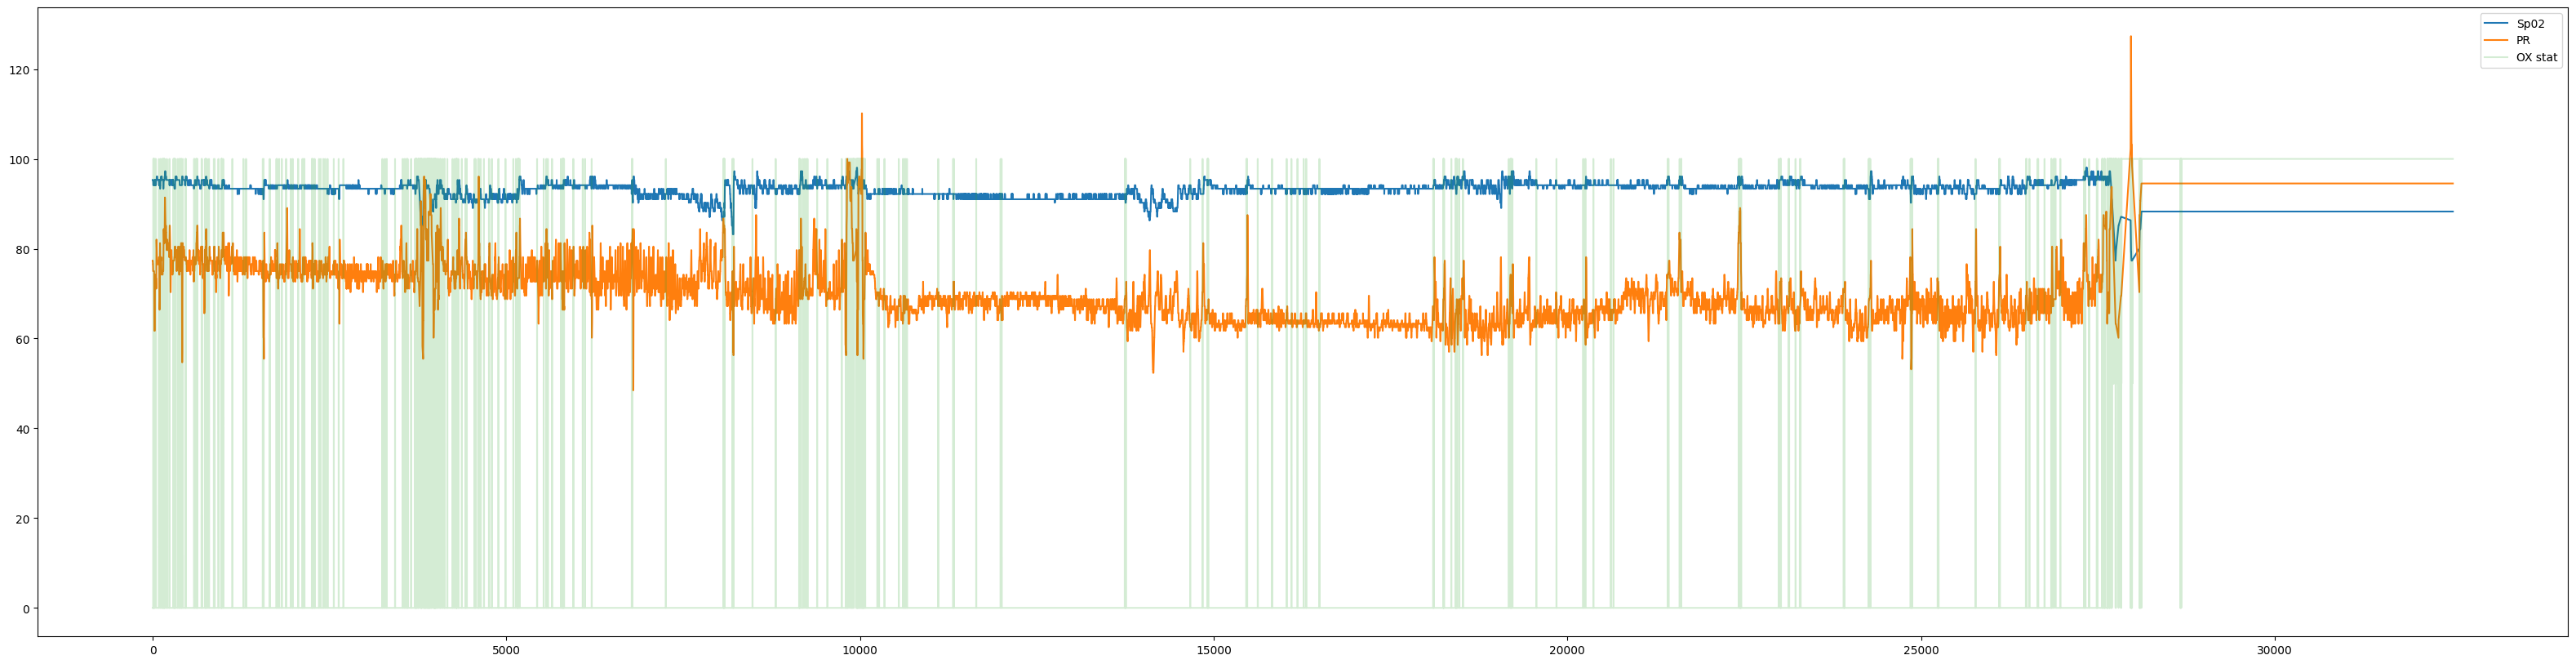

In [13]:
dataa = interpolate_bad_samples(edf)
print(dataa.shape)
plt.figure(figsize=(40, 10))

sns.lineplot(dataa[0], label='Sp02')
sns.lineplot(dataa[1], label='PR')
sns.lineplot(dataa1[2] * 50, label='OX stat', alpha=0.2)

## Standardize 

In [14]:
def standardize(sig: np.ndarray):
    return (sig - sig.mean()) / sig.std()

def sub_mean(sig: np.ndarray):
    return sig - sig.mean()

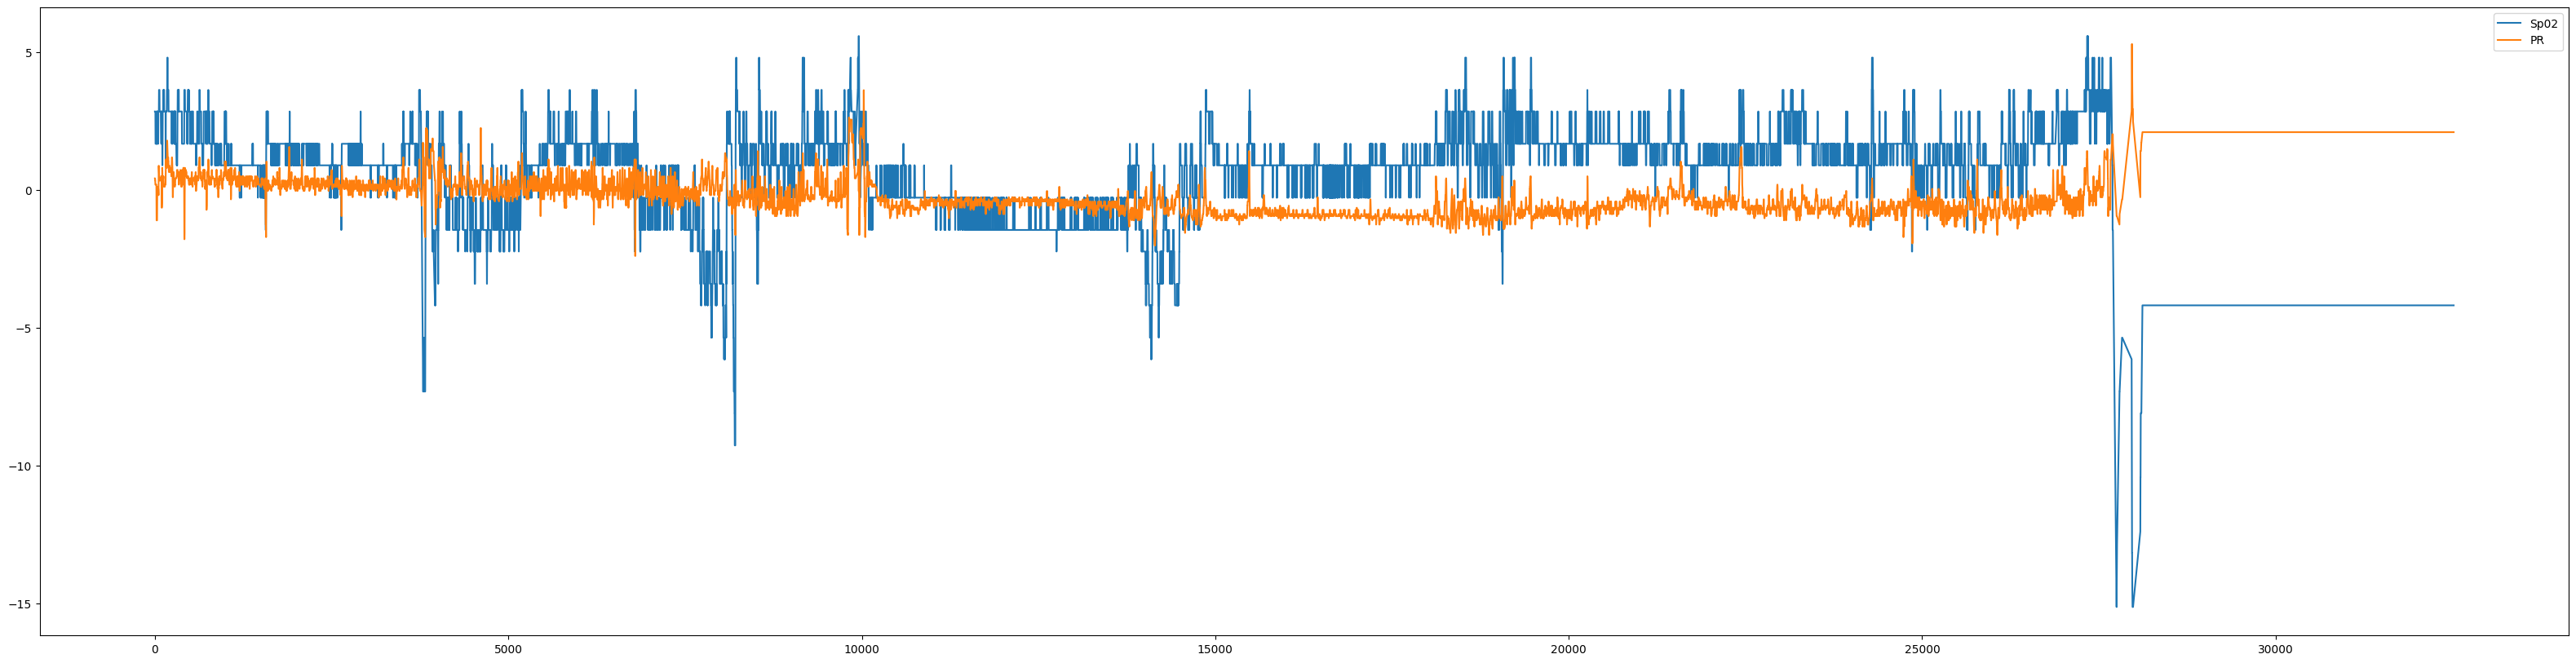

In [15]:
plt.figure(figsize=(40, 10))
sns.lineplot(sub_mean(dataa[0]), label='Sp02')
sns.lineplot(standardize(dataa[1]), label='PR')
plt.show()

## Desaturation

In [16]:
import numpy as np

def detect_desaturation_events(
    SpO2, 
    sampling_rate=1, 
    SpO2drop=2.9,  # A SpO2drop value of 2.9%
    window_baseline=60, # previous 60 s window
    event_duration=30, # if a drop ≥ SpO2drop from baseline (SpO2baseline ) occurs in the next 30 s
    max_event_duration=120 # event end: 3) 120 s
):
    """
    Detect desaturation events in SpO₂ data based on dynamic nadir calculation.
    
    Parameters:
    - SpO2: numpy array of SpO₂ values.
    - sampling_rate: Number of samples per second.
    - SpO2drop: Minimum drop from baseline to consider an event.
    - window_baseline: Baseline window size (in seconds).
    - event_duration: Duration to check for a drop (in seconds).
    - max_event_duration: Maximum allowed event duration (in seconds).
    
    Returns:
    - List of dictionaries with event start, end, and details.
    """
    baseline_samples = int(window_baseline * sampling_rate)
    event_samples = int(event_duration * sampling_rate)
    max_event_samples = int(max_event_duration * sampling_rate)
    
    events = []
    
    slopes = np.diff(SpO2, prepend=SpO2[0])
    
    i = baseline_samples  # Start after the first baseline window
    while i < len(SpO2) - event_samples:
        # Calculate SpO2baseline (mean of previous baseline_samples)
        SpO2baseline = np.mean(SpO2[i - baseline_samples:i])
        
        # Check for drops in the next event_duration
        future_window = SpO2[i:i + event_samples]
        nadir_index = np.argmin(future_window)
        nadir_value = future_window[nadir_index]
        
        drop = SpO2baseline - future_window
        if all(drop >= SpO2drop) and any(slopes[i:i + event_samples] <= -0.1): # with a slope ≥ 0.1% per second, diffs are calculated by next - previous pairs
            event_start = i
            
            # Event end based on conditions
            for j in range(event_start + 1, min(len(SpO2), 
                                                event_start + max_event_samples)): # Condition 3: Max duration
                event_end = j
                if (
                    SpO2[j] >= SpO2baseline - 1  # Condition 1: Returns to baseline - 1
                    or SpO2[j] >= 1.5 * nadir_value  # Condition 2: Reaches 1.5 × nadir
                ):
                    break
            
            # Append the detected event
            events.append((event_start, event_end))
            
            i = event_end
            continue
        
        i += 1
    
    return events


# Example Usage
SpO2 = dataa[0]

events = detect_desaturation_events(SpO2)
events

[(3776, 3830), (8166, 8215), (27693, 27812), (27966, 28085)]

In [17]:
# annotated desaturation (should be ignored according to: https://ieeexplore.ieee.org/document/8322241/)
annott = edf.annotations
adf = annott.to_data_frame()
adf['lower_desc'] = adf['description'].str.lower()
desat_df = adf[adf['lower_desc'].str.contains('desat')].copy()

start_time = adf[adf['description'].str.contains('Recording Start Time')]['onset'].iloc[0]

desat_df["start_index"] = (desat_df["onset"] - start_time).dt.total_seconds().astype(int)
desat_df["end_index"] = (desat_df["start_index"] + desat_df["duration"]).astype(int)

desat_df


,onset,duration,description,ch_names,lower_desc,start_index,end_index
48,1985-01-02 00:12:38.500,10.4,SpO2 desaturation|SpO2 desaturation,"(SaO2,)",spo2 desaturation|spo2 desaturation,7958,7968
53,1985-01-02 00:20:26.500,12.9,SpO2 desaturation|SpO2 desaturation,"(SaO2,)",spo2 desaturation|spo2 desaturation,8426,8438
56,1985-01-02 00:22:58.100,11.0,SpO2 desaturation|SpO2 desaturation,"(SaO2,)",spo2 desaturation|spo2 desaturation,8578,8589
58,1985-01-02 00:25:35.600,10.8,SpO2 desaturation|SpO2 desaturation,"(SaO2,)",spo2 desaturation|spo2 desaturation,8735,8745
61,1985-01-02 00:27:14.500,13.2,SpO2 desaturation|SpO2 desaturation,"(SaO2,)",spo2 desaturation|spo2 desaturation,8834,8847
...,...,...,...,...,...,...,...
376,1985-01-02 03:51:05.600,35.4,SpO2 desaturation|SpO2 desaturation,"(SaO2,)",spo2 desaturation|spo2 desaturation,21065,21100
378,1985-01-02 03:52:07.200,16.1,SpO2 desaturation|SpO2 desaturation,"(SaO2,)",spo2 desaturation|spo2 desaturation,21127,21143
380,1985-01-02 03:52:39.700,65.1,SpO2 desaturation|SpO2 desaturation,"(SaO2,)",spo2 desaturation|spo2 desaturation,21159,21224
382,1985-01-02 03:53:47.300,43.3,SpO2 desaturation|SpO2 desaturation,"(SaO2,)",spo2 desaturation|spo2 desaturation,21227,21270


In [18]:
import plotly.graph_objects as go

# Create the line plot
fig = go.Figure()

# Add the main line
fig.add_trace(go.Scatter(x=list(range(len(dataa[0]))), y=dataa[0], mode="lines", name="Signal"))

# Add highlighted intervals
for start, end in events:
    fig.add_shape(
        type="rect",
        x0=start,
        x1=end,
        y0=dataa[0].min(),
        y1=dataa[0].max(),
        fillcolor="red",  # Semi-transparent red
        opacity=0.5,
        line_width=0,
    )

for i, row in desat_df.iterrows():
    fig.add_shape(
        type="rect",
        x0=row['start_index'],
        x1=row['end_index'],
        y0=dataa[0].min(),
        y1=dataa[0].max(),
        fillcolor="green",  # Semi-transparent blue
        opacity=0.4,
        line_width=0,
    )


# Customize layout
fig.update_layout(
    title="Line Plot with Highlighted Intervals",
    xaxis_title="Time",
    yaxis_title="Amplitude",
    showlegend=False,
)

fig.show()

# Put it all together

In [19]:
from multiprocessing import Pool, cpu_count

def process_record(args):
    record, rawedf = args
    SpO2, PR = interpolate_bad_samples(rawedf)
    desaturation_events = detect_desaturation_events(SpO2)
    SpO2 = sub_mean(SpO2)
    PR = standardize(PR)
    return {
        "Record": record,
        "SpO2,PR": np.vstack((SpO2, PR)),
        "Desat": desaturation_events,
        "Annot": rawedf.annotations,
    }

# Parallelize processing
def process_all_records(selected_records):
    with Pool(cpu_count() - 4) as pool:
        results = list(tqdm(pool.imap(process_record, selected_records.items()), total=len(selected_records)))
    
    # Convert results to a DataFrame
    df = pd.DataFrame(results)
    return df

# Call the function
df = process_all_records(selected_records)
df

100%|██████████| 20/20 [00:00<00:00, 48.65it/s]


,Record,"SpO2,PR",Desat,Annot
0,shhs1-200001,"[[2.8442491880858256, 2.8442491880858256, 2.84...","[(3776, 3830), (8166, 8215), (27693, 27812), (...","({'onset': 0.0, 'duration': 840.0, 'descriptio..."
1,shhs1-200002,"[[-0.26082502566329424, -0.26082502566329424, ...","[(2087, 2134), (2341, 2380), (2569, 2606), (27...","({'onset': 0.0, 'duration': 270.0, 'descriptio..."
2,shhs1-200003,"[[-1.6578136701780721, -1.6578136701780721, -1...","[(13942, 13974)]","({'onset': 0.0, 'duration': 5010.0, 'descripti..."
3,shhs1-200004,"[[-0.12337872529037952, 1.0485141563759157, 1....",[],"({'onset': 0.0, 'duration': 2460.0, 'descripti..."
4,shhs1-200005,"[[2.074733218149305, 2.074733218149305, 2.0747...","[(18816, 18851), (30631, 30677)]","({'onset': 0.0, 'duration': 600.0, 'descriptio..."
5,shhs1-200006,"[[2.675111564001867, 2.675111564001867, 2.6751...","[(788, 907), (14677, 14796), (21259, 21378), (...","({'onset': 0.0, 'duration': 3690.0, 'descripti..."
6,shhs1-200007,"[[1.475858436901106, 1.475858436901106, 1.4758...","[(8971, 9005), (14035, 14073)]","({'onset': 0.0, 'duration': 4200.0, 'descripti..."
7,shhs1-200008,"[[-0.4084205297330925, -0.4084205297330925, 0....","[(23676, 23795)]","({'onset': 0.0, 'duration': 2490.0, 'descripti..."
8,shhs1-200009,"[[1.3834492911275618, 1.3834492911275618, 0.21...","[(119, 195), (10441, 10475), (21118, 21149), (...","({'onset': 0.0, 'duration': 5190.0, 'descripti..."
9,shhs1-200010,"[[0.02609154324551355, 0.02609154324551355, 0....",[],"({'onset': 0.0, 'duration': 3420.0, 'descripti..."


# Split to segments

In [20]:
for i, row in df.iterrows():
    to_split = row['SpO2,PR']
    
    num_segments = to_split.shape[1] // SINGLE_ANNOT
    trimmed_array = to_split[:, :num_segments * SINGLE_ANNOT] # drop last
    row['SpO2,PR'] = np.split(trimmed_array, num_segments, axis=1)
    
    row['SpO2,PR'] = np.transpose(np.dstack(row['SpO2,PR']), (2, 0, 1))

df.iloc[0]['SpO2,PR'].shape

(1084, 2, 30)

# Assign label

1) If an epoch contains an entire apnea event, it is labeled positive;
2) If an event spans across multiple epochs, the first epoch is positive if at least 50% of the epoch has apnea, the last epoch is positive if at least 50% has apnea or if the first epoch has < 50% apnea; 
3) Any intermediate epochs, if present, are positive.

In [21]:
# (no commit yet)

## Consider desaturations

# Prepare train/test set

In [ ]:
import tensorflow as tf

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value.encode('utf-8')]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def _int64_feature(value):
    """Returns an int64_list from an integer or list of integers."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))


def serialize_example(og, ext, label, name=None):
    """Serialize the X and y data into a TFRecord example."""
    feature = {'ext': _float_feature(ext.flatten())}
    
    if label is not None:
        feature['label'] = _int64_feature(label.flatten())
    if name is not None:
        feature['name'] = _bytes_feature(name)
        
    return tf.train.Example(features=tf.train.Features(feature=feature)).SerializeToString()


In [23]:
# (no commit yet)